<a href="https://colab.research.google.com/github/nmkamble/FIONA-/blob/main/Failure_of_Two_Party_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

### The goal
In this project we aim to identify clusters of US adults based on input features relating to political ideology. We are motivated to investigate whether there are prominent groups of people who share the same views or background beyond the simple binary of left and right. We want to see if this clustering might reveal that the American people really fit a multi-party system, rather than the 2-party system that has dominated American politics so far.

Through clustering, we can determine the optimal k, the number of clusters that exist in the data. If k > 2 is well supported, this might show that more than 2 opposite, divisive political groups exist in the US, and that we should focus on fostering a system that can better represent all k groups.

If strong clusters are formed from those input features (political views) we can further explore the nature of those clusters. Will those clusters be strengthened if we include input features like demographic information and world views that are not directly related to politics? If so, those groups will not just represent political ideologies; they'll represent populations and views in general.

### The problem
Why is the problem important? The [failure of the two party system](https://goodparty.org/blog/article/5-reasons-the-two-party-system-is-bad-for-america) is well documented:
1. Two-party politics limits our options.
2. Two-party politics is polarizing.

Those who don't believe in all of the views of either party feel unrepresented. Faced with a "lesser of two evils" problem, a large portion of voters simply won't vote, leaving as little as 20% of the population's most extreme voters to elect representatives. On the other hand, voters who find themselves not fitting into a binary may feel pressured to slowly extremize. Voters and politicians who are already in one of the two parties may become increasingly extremic.

3. The two-party system squashes 3rd parties.

It is extremely difficult for a 3rd party to succeed, because votes towards a 3rd party are simply votes taken away from one of the major parties with which the 3rd party most closely aligns.

4. The two-party system promotes stagnation.

With two opposite parties sharing political power in any one administration, progress stagnates. Players on opposite teams do everything to prevent bills from another team from getting passed. And with two opposite parties exchanging positions of power every few years, legislation is constantly being done and undone.

The results of our predictive model could show that a 2 party system is fundamentally irrepresentative of the population and signal that we should rethink how we organize and categorize political beliefs.

### The dataset

The dataset we're using is the [General Social Survey](https://gssdataexplorer.norc.org/gss_data), a project of NORC at the University of Chicago. It contains current and historical data on a wide range of US adults, from general demographic information, to familial dynamics, to political ideologies, to general world views, attitudes, and mental health. Most features are in the form of survey questions, with answers on a qualitative scale.

# Data Prep

Installing and importing libraries.

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 741.3 kB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
import warnings
import sklearn as sklearn
import time
import sklearn.preprocessing
import sklearn.pipeline
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import GaussianNB
import sklearn.neural_network;
import os
import category_encoders as ce
import time
import datetime
import json
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/Colab Notebooks/ML-Final-Project')

Mounted at /content/drive


We load in the dataset.

In [ ]:
raw_data = pd.io.stata.read_stata("gss7222_r2.dta", convert_categoricals=False)
raw_data.head()

,year,id,wrkstat,hrs1,hrs2,evwork,occ,prestige,wrkslf,wrkgovt,...,agehef12,agehef13,agehef14,hompoph,wtssps_nea,wtssnrps_nea,wtssps_next,wtssnrps_next,wtsscomp,wtsscompnr
0,1972,1,1.0,NaN,NaN,NaN,205.0,50.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4446,NaN
1,1972,2,5.0,NaN,NaN,1.0,441.0,45.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8893,NaN
2,1972,3,2.0,NaN,NaN,NaN,270.0,44.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8893,NaN
3,1972,4,1.0,NaN,NaN,NaN,1.0,57.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8893,NaN
4,1972,5,7.0,NaN,NaN,1.0,385.0,40.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8893,NaN


# Data Prep
The raw data includes survey answers from 1972 to 2022.

The selection of questions on the survey has changed over time. Some questions from earlier years are no longer asked in recent years, and available response options change from year to year. Plus, we want to focus only on recent data, so we've selected survey responses from 2018 to be our main dataset.


In [ ]:
recent_data = raw_data[raw_data['year'] == 2018]

### Trimming NA columns and rows

We'll need to extract the questions (columns) that were asked in 2018, and the questions that have a healthy amount of answers.

Let's take a look at what missing values are present in the dataset.

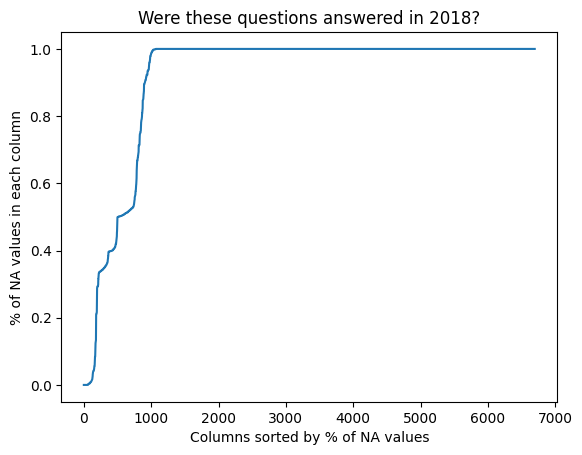

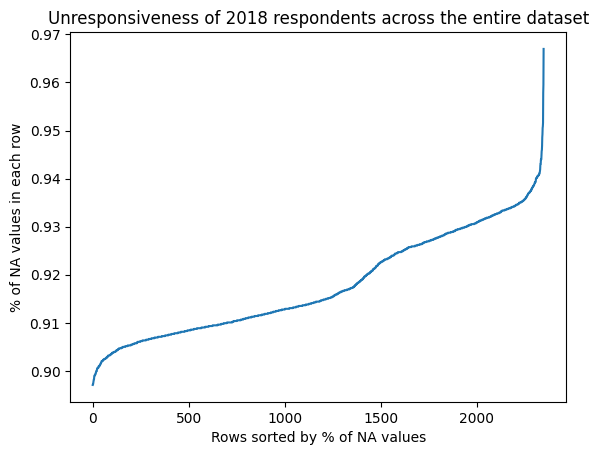

In [ ]:
def plot_NA_columns(data, title, show=True):
  out = data.apply(lambda x: x.isna().sum() / data.shape[0], axis=0) # x is a column in data
  plt.plot(np.arange(0, data.shape[1]), out.sort_values())
  plt.xlabel('Columns sorted by % of NA values')
  plt.ylabel('% of NA values in each column')
  if show:
    plt.title(title)
    plt.show()

plot_NA_columns(recent_data, title="Were these questions answered in 2018?")

def plot_NA_rows(data, title, show=True):
  out = data.apply(lambda x: x.isna().sum() / data.shape[1], axis=1) # x is a row in data
  plt.plot(np.arange(0, data.shape[0]), out.sort_values())
  plt.xlabel('Rows sorted by % of NA values')
  plt.ylabel('% of NA values in each row')
  if show:
    plt.title(title)
    plt.show()

plot_NA_rows(recent_data, title="Unresponsiveness of 2018 respondents across the entire dataset")

The study is formatted such that not all questions are asked to all participants. Rather, most of the questions are rotated so that a given question will likely only be on 2 of 3 versions (ballots) of the survey.

We'll only select responses that were in the same rotation. By doing this, we try to target a group of respondents who all answered the same questions.

In [ ]:
ballot1_2 = recent_data[recent_data['ballot'].isin([1, 2])]
ballot1_3 = recent_data[recent_data['ballot'].isin([1, 3])]
ballot2_3 = recent_data[recent_data['ballot'].isin([2, 3])]

Let's see how the number of NA values differs across these rotations.

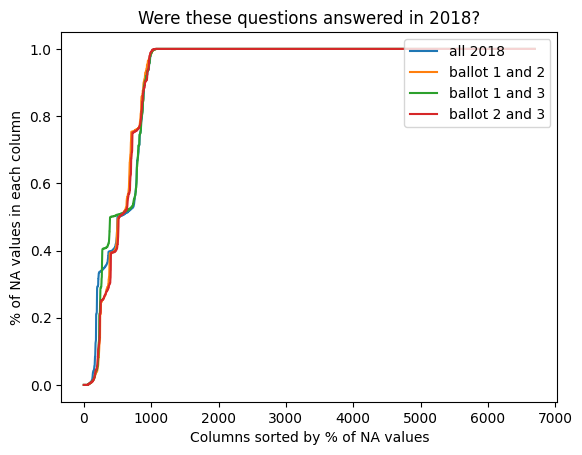

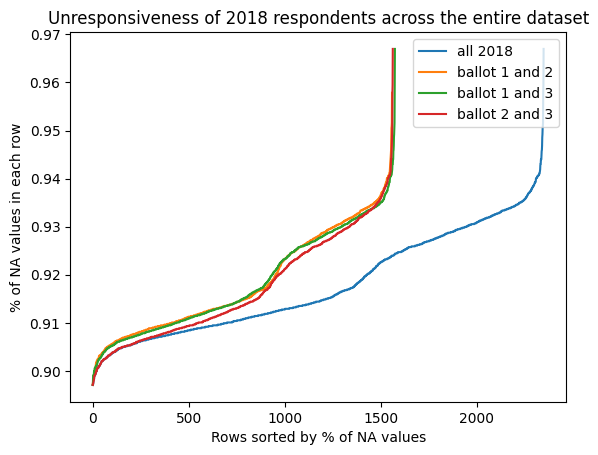

In [ ]:
def subplot_line_NA_col(ax, data):
  return ax.plot(np.arange(0, data.shape[1]),
                 data.apply(lambda x: x.isna().sum() / data.shape[0], axis=0).sort_values())

fig, ax = plt.subplots()
l1, = subplot_line_NA_col(ax, recent_data)
l2, = subplot_line_NA_col(ax, ballot1_2)
l3, = subplot_line_NA_col(ax, ballot1_3)
l4, = subplot_line_NA_col(ax, ballot2_3)
ax.legend((l1, l2, l3, l4), ('all 2018', 'ballot 1 and 2', 'ballot 1 and 3', 'ballot 2 and 3'), loc='upper right')
ax.set_xlabel('Columns sorted by % of NA values')
ax.set_ylabel('% of NA values in each column')
ax.set_title('Were these questions answered in 2018?')
plt.show()

def subplot_line_NA_row(ax, data):
  return ax.plot(np.arange(0, data.shape[0]), data.apply(lambda x: x.isna().sum() / data.shape[1], axis=1).sort_values())

fig, ax = plt.subplots()
l1, = subplot_line_NA_row(ax, recent_data)
l2, = subplot_line_NA_row(ax, ballot1_2)
l3, = subplot_line_NA_row(ax, ballot1_3)
l4, = subplot_line_NA_row(ax, ballot2_3)
ax.legend((l1, l2, l3, l4), ('all 2018', 'ballot 1 and 2', 'ballot 1 and 3', 'ballot 2 and 3'), loc='upper right')
ax.set_xlabel('Rows sorted by % of NA values')
ax.set_ylabel('% of NA values in each row')
ax.set_title('Unresponsiveness of 2018 respondents across the entire dataset')
plt.show()

Based on the above plots, ballots 2 and 3 have the lowest percentage of NA values so we'll focus on using that rotation.

From there, we remove any columns with more than 40% NA values since this likely means those questions either weren't asked in 2018 or weren't part of this rotation.

(1563, 480)


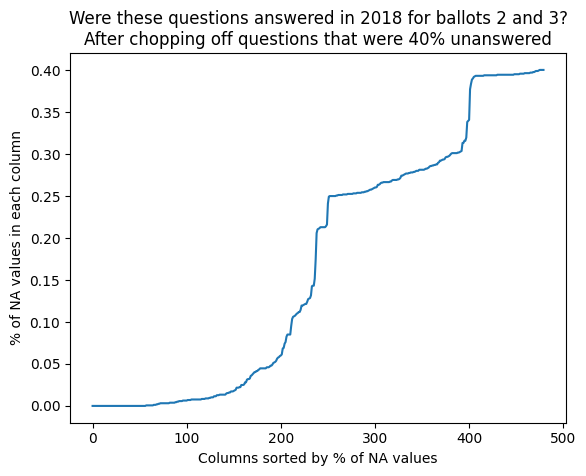

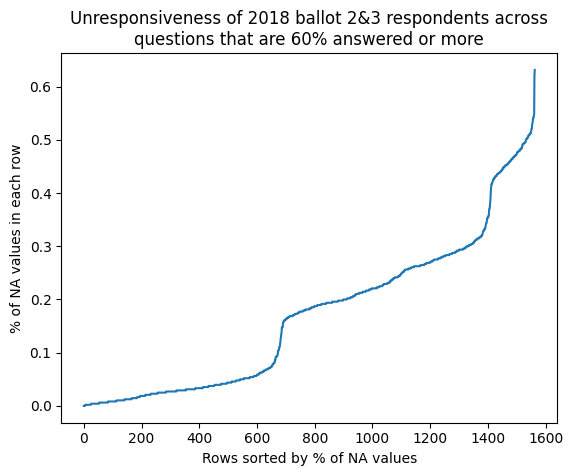

In [ ]:
def drop_cols(orig_data, percent_NA_cols_required, cols_title='', rows_title='', show_plot=False):
  select_data = orig_data.dropna(thresh=int(((1-percent_NA_cols_required) * orig_data.shape[0])), axis=1)
  if show_plot:
    print(select_data.shape)
    plot_NA_columns(select_data, title=cols_title)
    plot_NA_rows(select_data, title=rows_title)
  return select_data

percent_NA_cols_required = .4
select_data = drop_cols(ballot2_3, percent_NA_cols_required,
          cols_title='Were these questions answered in 2018 for ballots 2 and 3?\nAfter chopping off questions that were {}% unanswered'.format(int(percent_NA_cols_required * 100)),
          rows_title='Unresponsiveness of 2018 ballot 2&3 respondents across\nquestions that are {}% answered or more'.format(100 - int(percent_NA_cols_required * 100)),
          show_plot=True)

Let's drop unresponsive respondents (>8% NA) before more aggressively cutting NA columns so that unresponse respondents don't affect which columns are cut.

(1334, 480)


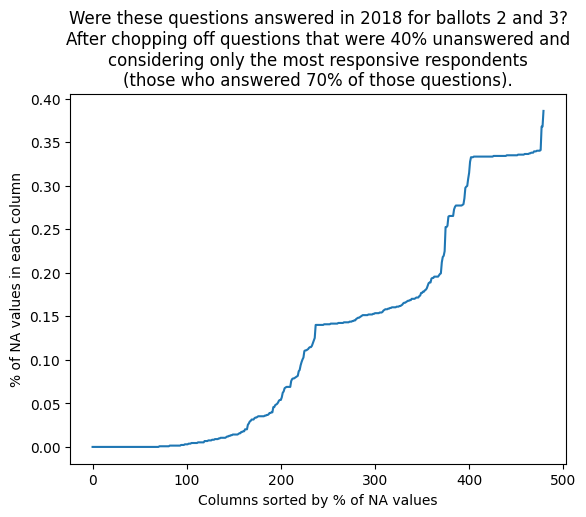

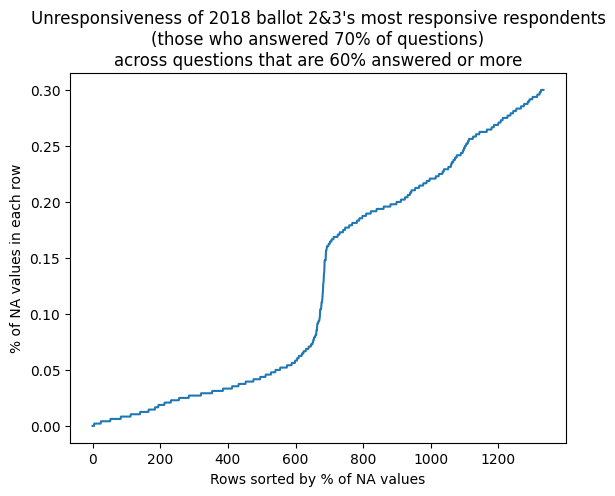

In [ ]:
def drop_rows(orig_data, percent_NA_rows_required, cols_title='', rows_title='', show_plot=False):
  answers_data = orig_data.dropna(thresh=int(((1-percent_NA_rows_required) * orig_data.shape[1])), axis=0)
  if show_plot:
    print(answers_data.shape)
    plot_NA_columns(answers_data, title=cols_title)
    plot_NA_rows(answers_data, title=rows_title)
  return answers_data

percent_NA_rows_required = .3
answers_data = drop_rows(select_data, percent_NA_rows_required,
          cols_title='Were these questions answered in 2018 for ballots 2 and 3?\nAfter chopping off questions that were {}% unanswered and\nconsidering only the most responsive respondents\n(those who answered {}% of those questions).'.format(int(percent_NA_cols_required * 100), 100 - int(percent_NA_rows_required * 100)),
          rows_title='Unresponsiveness of 2018 ballot 2&3\'s most responsive respondents\n(those who answered {}% of questions)\nacross questions that are {}% answered or more'.format(100 - int(percent_NA_rows_required * 100), 100 - int(percent_NA_cols_required * 100)),
          show_plot=True)

We'll now cut columns that are > 18% NA, as this seems to be where a plateau occurs in the column plot.

(1334, 355)


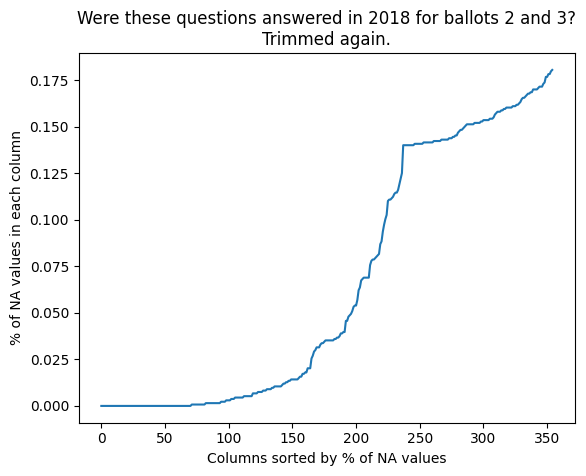

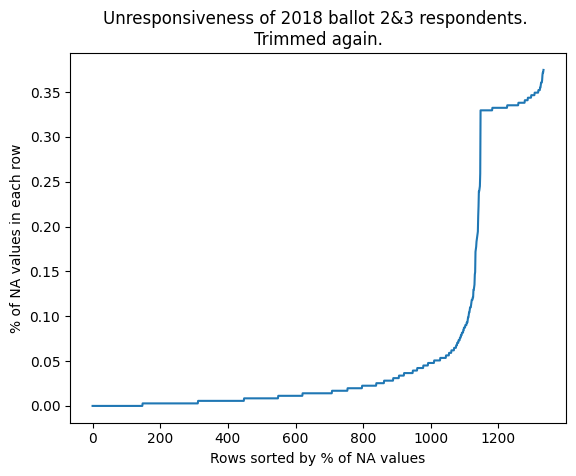

In [ ]:
percent_NA_rows_required = .18
trimmed = drop_cols(answers_data, percent_NA_rows_required,
          cols_title='Were these questions answered in 2018 for ballots 2 and 3?\nTrimmed again.',
          rows_title='Unresponsiveness of 2018 ballot 2&3 respondents. \nTrimmed again.',
          show_plot=True)

Finally, we cut off rows with > 5% NA values, since a vertical increase in NA values occurs thereafter.

(1028, 355)


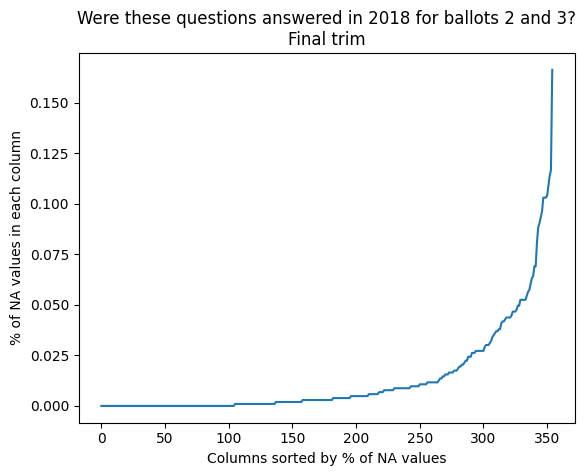

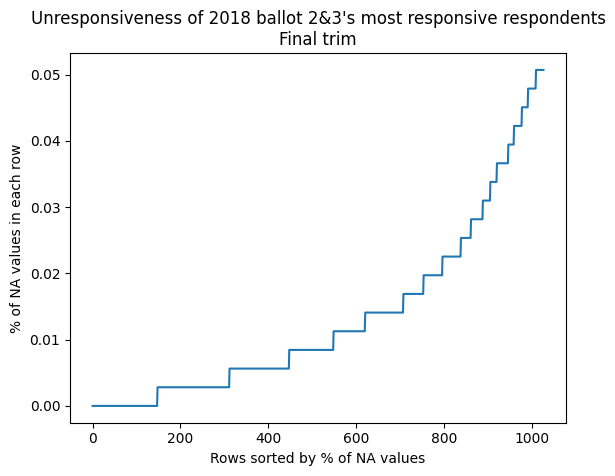

In [ ]:
trimmed = drop_rows(trimmed, 0.05,
          cols_title='Were these questions answered in 2018 for ballots 2 and 3?\nFinal trim',
          rows_title='Unresponsiveness of 2018 ballot 2&3\'s most responsive respondents\nFinal trim',
          show_plot=True)

### Feature Engineering

From the GSS website, we obtained a spreadsheet containing all of 2018's variable names and what they mean. It came in the form of 6 separate `csv`s, so we merged them here.

In [ ]:
codebook = pd.read_csv('Codebook/Variables-Table-1.csv')
codebook.head()
for i in range(2, 7):
  c = pd.read_csv('Codebook/Variables-Table-{}.csv'.format(i))
  codebook = pd.concat([codebook, c], axis=0)

codebook.drop(codebook.columns[[2, 3, 4]], axis=1, inplace=True)
codebook.to_csv('Codebook/merged-pandas-edit.csv')
# codebook = pd.read_csv('Codebook/merged-pandas-edit.csv') # storage
codebook.head()

,name,label
0,uswar,expect u.s. in war within 10 years
1,uswary,expect u.s. in world war in 10 years
2,ballot,ballot used for interview
3,wrkstat,labor force status
4,hrs1,number of hours worked last week


Now we trim the codebook to only contain variables present in our trimmed dataset.

In [ ]:
codebook['is_present'] = 0
for col in trimmed:
  codebook_entry = codebook.loc[codebook['name']==col]
  codebook.loc[codebook['name']==col, 'is_present'] = 1
codebook.head(10)

present_codebook = codebook[codebook['is_present'] == 1]
present_codebook.to_csv('Codebook/present-codebook.csv')
present_codebook.head()

,name,label,is_present
2,ballot,ballot used for interview,1
3,wrkstat,labor force status,1
14,age,age of respondent,1
16,educ,highest year of school completed,1
18,maeduc,"highest year school completed, mother",1


We manually added more information to `present_codebook`. This information includes a `tag` which denotes if a feature is related to political ideology (which we aim to use for clustering), demographic information, familial information, political-adjacent features (features that are not directly political but may influence political views), emotional health, lifestyle, religion, socioeconomic status, and work.

This is so we can categorize each type of question for feature selection.

In [ ]:
tagged_codebook = pd.read_csv('Codebook/present-codebook-tagged.csv')

tagged_codebook.drop_duplicates(subset='name', inplace=True)
tagged_codebook.head()

,Unnamed: 0,name,label,tag
0,2,ballot,ballot used for interview,omit
1,3,wrkstat,labor force status,work
2,14,age,age of respondent,demo
3,16,educ,highest year of school completed,social
4,18,maeduc,"highest year school completed, mother",social


Now let's take a look at the distribution of tags in our present features.

<Axes: xlabel='tag', ylabel='number of features'>

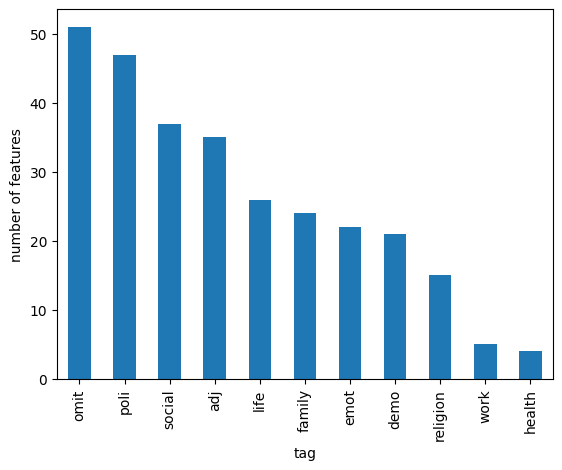

In [ ]:
fig, ax = plt.subplots()
ax.set_ylabel('number of features')
tagged_codebook['tag'].value_counts().plot(ax=ax, kind='bar')

One of the tags is called "omit", which denotes metadata about the interview itself. We'll omit those features from our analysis.

In [ ]:
def is_tag(col_name, tagged_codebook, tag):
    matches = tagged_codebook.loc[tagged_codebook['name'] == col_name]['tag']
    if not matches.empty:
        return matches.values[0] == tag
    return False

omitted = trimmed.drop(trimmed.columns[trimmed.apply(lambda col: is_tag(col.name, tagged_codebook, 'omit'))], axis=1)
print(trimmed.shape)
print(omitted.shape)


(1028, 355)
(1028, 304)


Let's take a look at the omitted data set.





In [ ]:
omitted.head()

,wrkstat,wrkslf,wrkgovt,occ10,prestg10,prestg105plus,indus10,marital,sibs,childs,...,sei10inc,inthisp,feelevel,dwellpre,kidsinhh,incuspop,neisafe,rlooks,rgroomed,rweight
62467,5.0,2.0,2.0,9640.0,22.0,13.0,4970.0,4.0,4.0,3.0,...,7.8,1.0,25.0,2.0,2.0,2.0,1.0,3.0,3.0,2.0
62469,1.0,2.0,2.0,3320.0,59.0,79.0,8190.0,1.0,3.0,2.0,...,68.4,1.0,25.0,2.0,1.0,2.0,1.0,4.0,3.0,3.0
62470,5.0,2.0,2.0,10.0,53.0,73.0,3390.0,3.0,3.0,0.0,...,76.4,NaN,75.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN
62472,1.0,2.0,1.0,3600.0,48.0,50.0,7580.0,3.0,7.0,6.0,...,11.3,1.0,25.0,3.0,2.0,3.0,3.0,3.0,3.0,2.0
62473,1.0,2.0,2.0,5610.0,35.0,27.0,4970.0,5.0,2.0,0.0,...,14.5,1.0,75.0,4.0,2.0,2.0,2.0,3.0,3.0,4.0


In [ ]:
omitted.describe()

,wrkstat,wrkslf,wrkgovt,occ10,prestg10,prestg105plus,indus10,marital,sibs,childs,...,sei10inc,inthisp,feelevel,dwellpre,kidsinhh,incuspop,neisafe,rlooks,rgroomed,rweight
count,1028.000000,1003.00000,983.000000,1003.00000,1000.000000,1000.00000,1001.000000,1027.000000,1026.000000,1028.000000,...,1000.000000,1019.000000,857.000000,1028.000000,1023.000000,1026.000000,1026.000000,921.000000,922.000000,922.000000
mean,2.873541,1.90329,1.803662,4238.29013,45.001000,50.06600,6345.104895,2.678676,3.351852,1.753891,...,43.998400,1.290481,48.691949,3.252918,1.714565,2.090643,1.549708,3.326819,3.484816,2.687636
std,2.269900,0.29571,0.397429,2683.61558,13.663077,25.96131,2704.843297,1.695069,2.582111,1.633610,...,26.993762,3.086509,23.370059,2.292242,0.451842,0.643595,0.684294,0.762310,0.825942,0.736838
min,1.000000,1.00000,1.000000,10.00000,16.000000,6.00000,170.000000,1.000000,0.000000,0.000000,...,3.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.00000,2.000000,2310.00000,35.000000,27.00000,4870.000000,1.000000,1.000000,0.000000,...,18.900000,1.000000,25.000000,2.000000,1.000000,2.000000,1.000000,3.000000,3.000000,2.000000
50%,2.000000,2.00000,2.000000,4110.00000,45.000000,50.00000,7390.000000,2.000000,3.000000,2.000000,...,42.100000,1.000000,50.000000,2.000000,2.000000,2.000000,1.000000,3.000000,3.000000,3.000000
75%,5.000000,2.00000,2.000000,5810.00000,53.000000,73.00000,8270.000000,5.000000,5.000000,3.000000,...,67.525000,1.000000,75.000000,4.000000,2.000000,3.000000,2.000000,4.000000,4.000000,3.000000
max,8.000000,2.00000,2.000000,9830.00000,80.000000,97.00000,9790.000000,5.000000,16.000000,8.000000,...,96.000000,50.000000,75.000000,10.000000,2.000000,3.000000,4.000000,5.000000,5.000000,5.000000


We impute missing values.
We've chosen to use an iterative imputer, a multivariate imputer that estimates each feature from all the others.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

omitted_imputed = pd.read_csv('omitted_imputed.csv').drop('Unnamed: 0', axis=1) # storage

omitted_imputed.head()


,wrkstat,wrkslf,wrkgovt,occ10,prestg10,prestg105plus,indus10,marital,sibs,childs,...,sei10inc,inthisp,feelevel,dwellpre,kidsinhh,incuspop,neisafe,rlooks,rgroomed,rweight
0,5,2,2,9640,22,13,4970,4,4,3,...,8,1,25,2,2,2,1,3,3,2
1,1,2,2,3320,59,79,8190,1,3,2,...,68,1,25,2,1,2,1,4,3,3
2,5,2,2,10,53,73,3390,3,3,0,...,76,1,75,2,1,1,1,3,4,3
3,1,2,1,3600,48,50,7580,3,7,6,...,11,1,25,3,2,3,3,3,3,2
4,1,2,2,5610,35,27,4970,5,2,0,...,14,1,75,4,2,2,2,3,3,4


We recode one of the features, `partyid`, which was originally on a finer grained ordinal scale, to be a feature with only 4 categories.

In [ ]:
omitted_imputed.replace({
    'partyid': {
        0: 0, # democrat
        1: 0,
        2: 0,
        3: 1, # independent
        4: 2, # republican
        5: 2,
        6: 2,
        7: 3 # other
    },
    'income': { # 12 is the max income value
        13: 12
    }
}, inplace=True)

omitted_imputed['partyid']

We also recode 3 other features. `abmoral` (moral opposition to abortion) is recoded so that the moderate view is in the middle. `courts` (do courts deal too harshly or not harshly enough with criminals?) is also recoded for that purpose. `racecen1` is recoded so that Asians and Pacific Islanders are aggregated into 2 single categories so that the categories are only white, black, native, Asian, Pacific Islander, Hispanic, and other.

In [ ]:
print(omitted_imputed[['abmoral', 'courts', 'racecen1']])

omitted_imputed.replace({
    'abmoral': { # 1: morally opposed, 2: it depends, 3: not morally opposed
        3: 2,
        2: 3
    },
    'courts': { # 1: too harshly, 2: about right, 3: not harshly enough
        3: 2,
        2: 3
    }
}, inplace=True)

omitted_imputed.replace({
    'racecen1': {
        5: 4, 6: 4, 7: 4, 8: 4, 9: 4, 10: 4, # aggregate all Asians
        11: 14, 12:14, 13: 14                # aggregate all pacific islanders
    }
}, inplace=True)

print(omitted_imputed[['abmoral', 'courts', 'racecen1']])

The industry code `indus10` is based on the 2017 census industry code list. It is currently too fine-grained (has too many categories), so we aggregate them into their 14 super-categories based on the information located [here (Census 2017 Industry Code List with Crosswalk)](https://www.census.gov/topics/employment/industry-occupation/guidance/code-lists.html).

This is to reduce the cardinality of `indus10` values to avoid a sparse matrix. It also creates some meaning, as similar industry jobs will be associated with one another by sharing a super-category.



In [ ]:
print(omitted_imputed['indus10'])

super_categories = {
    'Agriculture, Forestry, Fishing, and Hunting': range(170, 490),
    'Construction': range(770, 770),
    'Manufacturing': range(1070, 3990),
    'Wholesale Trade': range(4070, 4590),
    'Retail Trade': range(4670, 5790),
    'Transportation and Warehousing, and Utilities': range(6070, 6390),
    'Information': range(6470, 6780),
    'Finance and Insurance, and Real Estate and Rental and Leasing': range(6870, 7190),
    'Professional, Scientific, and Management, and Administrative': range(7270, 7790),
    'Educational Services, and Health Care and Social Assistance': range(7860, 8470),
    'Arts, Entertainment, and Recreation, and Accommodation and Food Services': range(8561, 8690),
    'Other Services, Except Public Administration': range(8770, 9290),
    'Public Administration': range(9370, 9590),
    'Military': range(9670, 9870),
}

def map_to_super_category(industry_code):
    for super_category, codes in super_categories.items():
        if industry_code in codes:
            return super_category
    return 'Other'

omitted_imputed['indus10'] = omitted_imputed['indus10'].apply(map_to_super_category)

print(omitted_imputed['indus10'])

### Data Exploration

Let's make a correlation matrix to see what variables in our data are most correlated/associated with one another.

In [ ]:
import seaborn as sns

numeric_data = omitted_imputed.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

most_correlated = correlation_matrix.columns[((correlation_matrix.abs() >= 0.85) & (correlation_matrix.abs() < 1)).any()]
plt.title('Correlation Matrix for Numeric Variables in Trimmed Dataset with Correlation Coefficient >= 0.85')
sns.heatmap(omitted_imputed[most_correlated].corr(), annot=False, cmap='coolwarm')
plt.show()

NameError: name 'omitted_imputed' is not defined

Because our dataset has so many variables, we decided to only plot the most correlated ones, those with a correlation coefficient of more than 0.85, and those not perfectly correlated on the matrix for better readability. As you can see some of the most correlated features include education/degree level and occupational prestige score, education/degree level and socieoeconomic index, occupational presitge and socieoecnomic index, and occupational code and socieconomic index. All of these correlations seem accurate and unsurprising given the clear relationships between the variables. It is however interesting that none of the responses to political beliefs shared any strong correlations. ###### not sure if this is right/i'm interepreting this correctly.

Let's see the distribution of `partyid` in our current dataset. According to the graph, most most respondents are more skewed to the left with the least number of respondents affiliated with a party other than democrat, republican, or independent.

In [ ]:
fig, ax = plt.subplots()
ax.set_ylabel('Frequency')
omitted_imputed['partyid'].value_counts().sort_index().plot(ax=ax, kind='bar')
ax.set_xticklabels(labels=['democrat', 'independent', 'republican', 'other'])

We also thought it might be interesting to explore the distribution of political affiliation across a select few demographic groups.

In [ ]:
import matplotlib.pyplot as plt
demographic_features = {
    'sex': ['female', 'male'],
    'race': ['white', 'black', 'other'],
    'region': ['new england', 'middle atlantic', 'east north central', 'west north central', 'south atlantic', 'east south atlantic', 'west south central', 'mountain', 'pacific'],
    'income': ['< $1k', '$1-3k', '$3-4k', '$4-5k', '$5-6k', '$6-7k', '$7-8k', '$8-10k', '$10-15k', '$15-20k', '$20-25k', '> $25k'],
    'sexornt': ['heterosexual', 'bisexual', 'homosexual'] # TODO: i think this labeling is backwards
}


for feature, values in demographic_features.items():
  counts = omitted_imputed.groupby([feature])['partyid'].value_counts().sort_index(axis=0)
  ax = counts.unstack().plot(kind='bar', title=feature)
  ax.set_xticklabels(values)
  ax.legend(labels=['democrat', 'independent', 'republican', 'other'])



In [ ]:
# stacked histogram of age and partyid

import seaborn as sns

demographic_features = ['age', 'sex', 'race', 'region', 'income', 'sexornt']
fig, axes = plt.subplots()
sns.histplot(data=omitted_imputed, x=omitted_imputed['age'], hue='partyid', multiple='stack', ax=axes)
axes.set_xlabel('age')
axes.set_ylabel('Frequency')
axes.legend(labels=['other', 'republican', 'independent', 'democrat'])
plt.show()


From these graphs, we see that between the ages of 20 - 50, the proportion of respondents that identify as democrats are higher than the proportion of respondents that identify as republican. While at age 65, there is a higher proportion of democratic respondents versus republican respondents, most age groups above 60 have relatively even split between republican and democratic respondents.

Heat Maps

Political and Social Beliefs: Variables like polviews, partyid, abmoral, cappun, polhitok, etc., can be grouped to see how political affiliations correlate with views on controversial topics.

Societal Views and Personal Behaviors: Including variables like grass (marijuana legalization), pornlaw, eqwlth (government should reduce income differences), and helpfrds to see how societal views correlate with personal moral and ethical standards.

In [ ]:
import seaborn as sns

#heatmap for political and social beliefs
pol_social_columns = omitted_imputed[['polviews', 'abmoral', 'cappun', 'polhitok']]
pol_social_corr = pol_social_columns.corr()

#heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pol_social_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Political and Social Beliefs')
plt.show()

In [ ]:
#societal views and personal behaviors
societal_behavior_columns = omitted_imputed[['grass', 'pornlaw', 'eqwlth', 'helpfrds']]
societal_behavior_corr = societal_behavior_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(societal_behavior_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Societal Views and Personal Behaviors')
plt.show()

In [ ]:
# some functions for feature selection

def is_tag(col_name, tagged_codebook, tag):
  return (tagged_codebook.loc[tagged_codebook['name'] == col_name]['tag']).values[0] == tag

def get_codebook_info(col_name, category):
  codebook_entry = tagged_codebook.loc[tagged_codebook['name'] == col_name]
  if (codebook_entry.empty):
    return None
  else:
    return codebook_entry[category].values[0]

def is_not_category(col_name, category, category_to_keep):
  result = get_codebook_info(col_name, category)
  return (result != category_to_keep)

def keep_column(df, category, category_to_keep):
  return df.drop(df.columns[df.apply(lambda col: is_not_category(col.name, category, category_to_keep))], axis=1)

def is_not_tag(col_name, tagged_codebook, tag):
  return is_not_category(col_name, 'tag', tag)

def is_categorical(col_name, tagged_codebook):
    return get_codebook_info(col_name, 'encode') == 'Y'

Next we wanted to look at the distribution of features we have determined are political in nature.

In [ ]:
poli_data = keep_column(omitted_imputed, 'tag', 'poli')

for feature in poli_data:
  # poli_data[feature].plot(kind='bar', title='answers for {} ({})'.format(feature, (tagged_codebook.loc[tagged_codebook['name']==feature])["label"].values[0]))
  # plt.show()
  counts = omitted_imputed[feature].value_counts().sort_index(axis=0)
  ax = counts.plot(kind='bar', title=feature)
  plt.show()
  # ax.set_xticklabels(values)
  # ax.legend(labels=['democrat', 'independent', 'republican', 'other'])


To calculate clustering tendency, we are calculating the Hopkins statistic. A value close to 0.5 suggests randomness, close to 0 indicates regularly-spaced data, and close to 1 indicates high clustering potential.

We calculate the Hopkins Statistic of the entire dataset as well as only the political data.

In [ ]:
def hopkins_statistic(data):
    rows, cols = data.shape
    neighbors = NearestNeighbors(n_neighbors=1).fit(data)

    m = int(0.2 * rows)
    random_points = pd.DataFrame(np.random.uniform(data.min(axis=0), data.max(axis=0), (m, cols)), columns=data.columns)

    randDistances_ = neighbors.kneighbors(random_points, n_neighbors=1)
    randSum = randDistances_[1].sum()

    #sampling m actual data points
    shuffled_data = shuffle(data, random_state=0)
    sample = shuffled_data.iloc[:m]

    pointDistances = neighbors.kneighbors(sample, n_neighbors=1)
    pointsSum = pointDistances[1].sum()
    hopkins = randSum / (randSum + pointsSum)
    return hopkins

print("Hopkins Statistic:", hopkins_statistic(pd.get_dummies(omitted_imputed)))

In [ ]:
poli_data = omitted_imputed.drop(omitted_imputed.columns[omitted_imputed.apply(lambda col: is_not_tag(col.name, tagged_codebook, 'poli'))], axis=1)
print("Hopkins Statistic:", hopkins_statistic(poli_data))

Both Hopkins Statistics indicate that the data does not have a high clustering tendency and that meaningful clusters will likely not be formed.

# Clustering

For completeness and out of curiosity, we tried one clustering with a K-means algorithm and DBSCAN.

We are looking to see what clusters we can find from K-means.

In [ ]:
from sklearn.cluster import KMeans
sse = [];
for k in range(2,11):
  kmeans = KMeans(n_clusters = k, init = 'k-means++')
  kmeans.fit(transformed)
  sse.append(kmeans.inertia_)

plt.figure()
plt.plot(range(2,11), sse)
plt.title('SSE vs k')
plt.xlabel('K')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

In [ ]:
#using a k value of 5 accroding to the elbow method

kmeans = KMeans(n_clusters = 4)
kmeans.fit(transformed)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
plt.scatter(transformed.iloc[:, 0], transformed.iloc[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black')
plt.title(f"K-Means Clustering with k=5")
plt.show()

To run DBSCAN, we first used PCA to reduce dimensionality and hopefully combat the curse of dimensionality.

In [ ]:
import sklearn.preprocessing

scaler = sklearn.preprocessing.StandardScaler(with_mean = True, with_std = True)
pca = sklearn.decomposition.PCA(n_components = .7, svd_solver = 'full')
transformed = pd.DataFrame(pca.fit_transform(scaler.fit_transform(poli_data)))
print(poli_data.shape)
print(transformed.shape)
transformed.head()

We determine the best eps by looking at the graph of distances to a kth nearest neighbor and how it changes with different k values.

In [ ]:
from sklearn.neighbors import NearestNeighbors

minpts = 4
nearest = NearestNeighbors(n_neighbors = minpts)
nearest.fit(transformed)
(dists, ind) = nearest.kneighbors()

distances = dists[:, minpts - 1]
distances.sort()
plt.plot(distances)
plt.xlabel("Points sorted by distance to {}th nearest neighbor".format(minpts))
plt.ylabel("Distance to {}th nearest neighbor".format(minpts))

eps = 6
plt.axhline(y=eps, color='r', linestyle='-')
plt.show()

The best eps appears to be 6. We now run the DBSCAN algorithm.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
import random

clusters = DBSCAN(eps = eps, min_samples = minpts)
predicted = clusters.fit_predict(transformed)

print(type(transformed))
def scatter(data, labels, numPoints = 300):

    numEntries = data.shape[0]
    start = random.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data.iloc[start:end, :]
    labels = labels[start:end]

    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data)
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

scatter(transformed, predicted)

The resulting clusters do not appear to cluster the data well, though the data is not very clusterable to begin with. The data is very globular.

# Change of Plans

After determining that clustering is not fitting for the data, we decided to change our goal.

We now want to turn the problem into a classification problem. Based on demographic information that a political organization might have information on (such as race, income, region, sex, etc.), can we predict a person's political stance on issues like government spending on social security and whether the marijuana should be legalized?

Our predictions can be used in the context of political organizations trying to target certain populations based on an issue they might be interested in, in order to elicit voter action, such as voting, signing petitions, donating, and general civil participation.

Our targets are:


* Do you have a moral opposition to abortion?
* What party do you affiliate with?
* How much should the government spend on each of the following?
  - highways and bridges
  - social security
  - mass transportation
  - parks and recreation
  - assistance for childcare
  - supporting scientific research
  - developing alternative energy sources
* Should the government reduce income differences?
* Do you favor or oppose the death penalty for murder?
* Do you think courts deal too harshly or not harshly enough with criminals?
* Should marijuana be made legal?
* Should there be laws against the distribution of pornography?
* Should the government help pay for medical care?
* Should the government aid blacks?



# Data Exploration (Pt 2)

We print a correlation matrix for features that are tagged family, political, religion, social, and work--categories which a political organization may have access to. (Leaving out intimate survey questions included in the original dataset, like "How often in the past 4 weeks have you felt isolated from others?")

In [ ]:
def is_tag_list(col_name, tagged_codebook, tag_list):

  for tag in tag_list:
    if get_codebook_info(col_name, 'tag') in tag_list:
      return True
  return False

remove_list = ["adj", "life", "emot", "health"]
corr_data = omitted_imputed.drop(omitted_imputed.columns[omitted_imputed.apply(lambda col: is_tag_list(col.name, tagged_codebook, remove_list))], axis=1).select_dtypes(include=[np.number])
corr_matrix = corr_data.corr()

print(corr_matrix.to_string())


To explore more, we print the features (any features) with the highest (absolute) correlation to each political label.

In [ ]:
def is_not_poli_filter(row):
  codebook_entry = tagged_codebook.loc[tagged_codebook['name'] == row.name]
  if not codebook_entry["tag"].empty:
    return codebook_entry["tag"].values[0] != "poli"
  return False

for col_name, col in corr_matrix.items():
  codebook_entry = tagged_codebook.loc[tagged_codebook['name'] == col_name]

  if (not codebook_entry["type"].empty and codebook_entry["type"].values[0] == "L"):
    not_poli_filter = col.to_frame().transpose().apply(is_not_poli_filter)

    filtered_col = col[not_poli_filter]

    print('\n', codebook_entry["name"].values[0], codebook_entry["label"].values[0])
    print(filtered_col.abs().sort_values(ascending = False)[:15])

Now we separate features and labels. We have selected columns to be our features and columns to be labeled, denoted in our custom codebook. We mostly selected basic demographic features that would be realistic for an organization to get ahold of.

In [ ]:
real_features = keep_column(omitted_imputed, "type", "Y")
all_labels = keep_column(omitted_imputed, "type", "L")

print("real_features:\n", real_features.head())
print("all_labels:\n", all_labels.head())

Now we'll perform one-hot encoding on our features.

In [ ]:
categorical = []
for col in real_features.columns:
  # print(col)
  if is_categorical(col, tagged_codebook):
    categorical.append(col)

print("categorical vars to encode:", categorical)

# original DataFrame columns
print("Original real features:")
print(real_features.head())

real_features = pd.get_dummies(real_features, columns=categorical)

# encoded DataFrame columns
print("\n One-hot Encoded DataFrame columns:")
print(real_features.head())

# Supervised Modeling

In [ ]:
# a function for printing dictionaries
# source: https://stackoverflow.com/a/3229493/23295350

def pretty_print(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty_print(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

We will try a variety of different classifiers:
* Decision tree
* Gradient Boosted Decision Tree
* Naive Bayes
* KNN
* SVM
* Neural network

Printing confusion matrix and classification report

In [ ]:
'''
print classification report and confusion matrix
return accuracy
'''
def print_confusion_classification(model, real_features, all_labels, label_name, cv=5):
  #cross_val_predict to get the predicted y values for every record
  predicted_y = cross_val_predict(model, real_features, all_labels[label_name], cv=cv)

  print("Confusion Matrix:")
  print(confusion_matrix(all_labels[label_name], predicted_y))

  print("\nClassification Report:")
  print(classification_report(all_labels[label_name], predicted_y))

  return accuracy_score(all_labels[label_name], predicted_y)


*Decision tree*

In [ ]:
def decision_tree (real_features, all_labels, label_name, cv=5):
  my_tree = DecisionTreeClassifier()
  loo_encoder = ce.leave_one_out.LeaveOneOutEncoder(cols='eth1')
  my_pipe = sklearn.pipeline.Pipeline([('encoder', loo_encoder), ('my_tree', my_tree)])

  # defining parameter range
  param_grid = {
      'my_tree__max_depth': [5, 10, 15, 20],
      'my_tree__max_features': [5, 10, 20],
      'my_tree__min_samples_split': [10, 20, 40]
  }

  #nested cross validation
  grid_search = GridSearchCV(my_pipe, param_grid, cv=5, scoring='accuracy')
  grid_search.fit(real_features, all_labels[label_name])
  print("Best value for each parameter:")
  pretty_print(grid_search.best_params_, indent=1)
  print("Accuracy for parameters:", grid_search.best_score_)

  #nested cross-validation with cross_val_score
  # nested_score = cross_val_score(grid_search, real_features, all_labels[label_name], cv=cv)
  # print("Accuracy:", nested_score.mean())

  return print_confusion_classification(grid_search, real_features, all_labels, label_name, cv=cv)
  # return (grid_search, nested_score.mean())
  # return report

*Gradient Boosted Decision Tree*

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
def gradient_boosting(real_features, all_labels, label_name, cv=5):
  my_tree = GradientBoostingClassifier()
  loo_encoder = ce.leave_one_out.LeaveOneOutEncoder(cols='eth1')
  my_pipe = sklearn.pipeline.Pipeline([('encoder', loo_encoder), ('my_tree', my_tree)])

  # defining parameter range
  param_grid = {
      'my_tree__max_depth': [5, 10, 15, 20],
      'my_tree__max_features': [5, 10, 20],
      'my_tree__min_samples_split': [10, 20, 40],
      'my_tree__n_estimatore': [100, 200, 300],
      'my_tree__learning_rate': [0.01, 0.1, 0.2]
  }

  #nested cross validation
  grid_search = GridSearchCV(my_pipe, param_grid, cv=5, scoring='accuracy')
  grid_search.fit(real_features, all_labels[label_name])
  print("Best value for each parameter:")
  pretty_print(grid_search.best_params_, indent=1)
  print("Accuracy for parameters:", grid_search.best_score_)

  #nested cross-validation with cross_val_score
  # nested_score = cross_val_score(grid_search, real_features, all_labels[label_name], cv=cv)
  # print("Accuracy:", nested_score.mean())

  return print_confusion_classification(grid_search, real_features, all_labels, label_name, cv=cv)
  # return (grid_search, nested_score.mean())
  # return report

*Naive Bayes*

In [ ]:
def naive_bayes(real_features, all_labels, label_name, cv=5):
  gaussian = GaussianNB()

  loo_encoder = ce.leave_one_out.LeaveOneOutEncoder(cols='eth1')
  my_pipe = sklearn.pipeline.Pipeline([('encoder', loo_encoder), ('my_gaussian', gaussian)])
  my_pipe.fit(real_features, all_labels[label_name])

  # cv_scores = cross_val_score(my_pipe, real_features, all_labels[label_name], cv=cv)
  # print("Accuracy:", cv_scores.mean())

  return print_confusion_classification(my_pipe, real_features, all_labels, label_name, cv=cv)
  # return my_pipe, cv_scores.mean()
  # return report

*KNN*

In [ ]:
def knn(real_features, all_labels, label_name, cv=5):
  loo_encoder = ce.leave_one_out.LeaveOneOutEncoder(cols='eth1')
  scaler = sklearn.preprocessing.StandardScaler(with_mean = True, with_std = True)
  pca = sklearn.decomposition.PCA()
  my_knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=7)
  my_pipe = sklearn.pipeline.Pipeline([('encoder', loo_encoder), ('scaler', scaler), ('pca', pca), ('my_knn', my_knn)])

  param_grid_knn = {
      'pca__n_components': list(range(5, real_features.shape[1] - 5, 2)),
      'my_knn__n_neighbors': list(range(2, 25, 2))
  }


  knn_grid = sklearn.model_selection.GridSearchCV(my_pipe, param_grid_knn, cv=cv)
  knn_grid.fit(real_features, all_labels[label_name])
  print("Best value for each parameter:")
  pretty_print(knn_grid.best_params_, indent=1)
  print("\tAccuracy for parameters:", knn_grid.best_score_)

  # accuracies = sklearn.model_selection.cross_val_score(knn_grid, real_features, all_labels[label_name], cv=cv)
  # print('average accuracy: ', accuracies.mean())

  return print_confusion_classification(knn_grid, real_features, all_labels, label_name, cv=cv)
  # return my_knn, accuracies.mean()
  # return report

*SVM*

In [ ]:
def svm(real_features, all_labels, label_name, cv=5):
  loo_encoder = ce.leave_one_out.LeaveOneOutEncoder(cols='eth1')
  scaler = sklearn.preprocessing.StandardScaler(with_mean = True, with_std = True)
  pca = sklearn.decomposition.PCA()
  my_svc = sklearn.svm.SVC();
  my_pipe = sklearn.pipeline.Pipeline([('encoder', loo_encoder), ('scaler', scaler), ('pca', pca), ('my_svc', my_svc)])
  param_grid = {
      'pca__n_components': list(range(5, real_features.shape[1] - 5, 2)),
      'my_svc__kernel': ('linear', 'rbf', 'poly')
  }

  svc_grid = sklearn.model_selection.GridSearchCV(my_pipe, param_grid, cv=cv)
  svc_grid.fit(real_features, all_labels[label_name])
  print("Best value for each parameter:")
  pretty_print(svc_grid.best_params_, indent=1)
  print("\tAccuracy for parameters:", svc_grid.best_score_)

  # accuracies = sklearn.model_selection.cross_val_score(svc_grid, real_features, all_labels[label_name], cv=cv)
  # print('average accuracy: ', accuracies.mean())

  return print_confusion_classification(svc_grid, real_features, all_labels, label_name, cv=cv)

  # return svc_grid, accuracies.mean()
  # return report

*Neural Network*

In [ ]:

@ignore_warnings(category=ConvergenceWarning)
def neural_net(real_features, all_labels, label_name, cv=5):
  loo_encoder = ce.leave_one_out.LeaveOneOutEncoder(cols='eth1')
  scaler = sklearn.preprocessing.StandardScaler(with_mean = True, with_std = True)

  my_nn = sklearn.neural_network.MLPClassifier()
  my_pipe = sklearn.pipeline.Pipeline([('encoder', loo_encoder), ('scaler', scaler),('my_nn', my_nn)])

  param_grid = {
      'my_nn__hidden_layer_sizes': [(10,), (20,), (30,)],
      'my_nn__activation': ['logistic', 'tanh', 'relu'],
  }


  nn_grid = sklearn.model_selection.GridSearchCV(my_pipe, param_grid, cv=cv)
  nn_grid.fit(real_features, all_labels[label_name])
  print("Best value for each parameter:")
  pretty_print(nn_grid.best_params_, indent=1)
  print("\tAccuracy for parameters:", nn_grid.best_score_)

  # accuracies = sklearn.model_selection.cross_val_score(nn_grid, real_features, all_labels[label_name], cv=cv)
  # print('average accuracy: ', accuracies.mean())

  return print_confusion_classification(nn_grid, real_features, all_labels, label_name, cv=cv)
  # return nn_grid, accuracies.mean()
  # return report

# Run nominal classifiers

Now we'll run each classifier on our target labels.

In [ ]:
warnings.filterwarnings('ignore') # TODO: how to get "precision and f score are illdefined" warning to stop printing
'''
return
{
  "neural net (nominal)": model, nn_accuracy,
  "svm (nominal)": model, svm_accuracy,
  "knn (nominal)": model, knn_accuracy,
  "naive bayes (nominal)": model, naive_accuracy,
  "decision tree (nominal)": model, dt_accuracy
}
'''
@ignore_warnings(category=ConvergenceWarning)
def run_models(real_features, all_labels, label):
  cv = 2
  print(label)
  print("Neural net")
  start = time.time()
  nn_acc = neural_net(real_features, all_labels, label, cv=cv)
  end = time.time()
  print("time elapsed:", str(datetime.timedelta(seconds=end-start)))

  print("\nSVM")
  start = time.time()
  svm_acc = svm(real_features, all_labels, label, cv=cv)
  end = time.time()
  print("time elapsed:", str(datetime.timedelta(seconds=end-start)))

  print("\nKNN")
  start = time.time()
  knn_acc = knn(real_features, all_labels, label, cv=cv)
  end = time.time()
  print("time elapsed:", str(datetime.timedelta(seconds=end-start)))

  print("\nNaive Bayes")
  start = time.time()
  naive_acc = naive_bayes(real_features, all_labels, label, cv=cv)
  end = time.time()
  print("time elapsed:", str(datetime.timedelta(seconds=end-start)))

  print("\nDecision Tree")
  start = time.time()
  dt_acc = decision_tree(real_features, all_labels, label, cv=cv)
  end = time.time()
  print("time elapsed:", str(datetime.timedelta(seconds=end-start)))

  accuracies = {
      "neural net (nominal)": nn_acc,
      "svm (nominal)": svm_acc,
      "knn (nominal)": knn_acc,
      "naive bayes (nominal)": naive_acc,
      "decision tree (nominal)": dt_acc
  }

  # models = {
  #     "nn": nn_model,
  #     "svm": svm_model,
  #     "knn": knn_model,
  #     "naive": naive_model,
  #     "dt": dt_model
  # }

  print(accuracies)
  return accuracies


'''
return
{
  "natsci":
    {
      "neural net (nominal)": model, nn_accuracy,
      "svm (nominal)": model, svm_accuracy,
      "knn (nominal)": model, knn_accuracy,
      "naive bayes (nominal)": model, naive_accuracy,
      "decision tree (nominal)": model, dt_accuracy
    },
  "natroad":
    {
      "neural net (nominal)": model, nn_accuracy,
      "svm (nominal)": model, svm_accuracy,
      "knn (nominal)": model, knn_accuracy,
      "naive bayes (nominal)": model, naive_accuracy,
      "decision tree (nominal)": model, dt_accuracy
    },
    ...
}
'''
def run_models_all_labels(real_features, all_labels):
  all_targets_acc = {}
  for label in all_labels:
    start = time.time()
    acc_for_label = run_models(real_features, all_labels, label)
    all_targets_acc[label] = acc_for_label
    end = time.time()
    print("total time elapsed:", str(datetime.timedelta(seconds=end-start)))
    print("************************************************************\n\n")
  return all_targets_acc

nominal_accuracies = run_models_all_labels(real_features, all_labels)
print(nominal_accuracies)

In [ ]:
# store nominal_accuracies in case we lose the variable in between run times.

import pickle

filename = 'nominal_accuracies'
filehandler = open(filename, 'wb')
pickle.dump(nominal_accuracies, filehandler) # pickle stores data in binary form. Unreadable by humans.

In [ ]:
# alternative way to store nominal_accuracies. is human readable.

with open('nominal_accuracies.json', 'w') as f:
    json.dump(nominal_accuracies, f)

In [ ]:
with open('nominal_accuracies.json') as f:
    nominal_accuracies = json.load(f)

In [ ]:
pretty_print(nominal_accuracies)

# Results (Nominal Classifiers)


Performance Overview: Overall, the SVM models generally show high accuracy across most targets, often being the best or one of the best models. In the grass, courts, and pornlaws categories it has the highest accuracies. The KNN models also show high performance in many categories. Neural Networks had varied performance but did well in predicting courts and grass. Decision trees have moderate performance across targets. Naive Bayes generally performs very poorly compared to all the other models.





Interpreting Results for PartyID:
The Neural Network performed with an accuracy of 50.19%, which indicates that about half of the predictions made by the model are correct. In terms of performance, it had moderate performance with Class 0 (Democrat) and Class 2 (Republican) better predicted than Class 1 (Independent) and Class 3 (Other). Class 3 in particular had very poor performance with a precision of 0.
The SVM model performed slightly better with an accuracy of 53.11%. It had a performance similar to the neural network in the sense that Classes 0 and 2 are predted better.
The KNN model performed even better, with an accuracy of 54.28%. This model still struggles with Classes 1 and 3, but had improved accuracy for Class 0.
The Naive Bayes model has a very low accuracy of 19.45%. This model has performed the poorest with many misclassifications across all classes. It significantly overly predicts Class 3, possibly due to its assumptions about feature independence.
The Decision Tree performed similarly to the Neural Network.
Overall, for predicting partyid, KNN has the highest accuracy and performs somewhat consistently across classes except for Class 3. All the models struggle with Class 3 (which is “Other”), which makes sense because of the class imbalance since there are a smaller number of instances. This also applies to Class 1 (“Independent”).

Interpreting Results for Natroad: Overall, the models were able to predict how much the government should spend on highways and bridges slightly better than it could predict party. The KNN model performed with an accuracy of 558.27%. It performed moderately well for Class 1 (Too Little) especially, but Class 3 (Too Much) was poorly predicted with a low recall and precision. The Decision Tree had the best accuracy of 58.56%, it performed well for Class 1 but like the other models failed to predict Class 3 corrctly. The Decision Tree and SVM models have higher accuracies but are heavily biased towards predicting Class 1 which leads to high recall but bad balanced accuracy across all classes.

Interpreting Results for natsoc, natmass, natpark, natchld, natsci, natenrgy:
Let's interpret the results of the  performance of these classifiers over various policy domains.
A common theme across all these targets it the difficulty in predicting minority classes, with classifiers consistently underperforming on these classes as seen with many zero scores across metrics.
Although no single model consistently outperforms others, SVM and KNN are generally stronger models with high accuracies. The accuracy levels for most of the models are around 50-60%. The weighted averages of precision, recall, and F1 scores are generally higher than the macro averages, which indicates that the majority classes are the ones driving the metrics which confirms the problem with class imbalance.


Interpreting Results for eqwlth: This target is predicting opinions on if the government should reduce income differences. All the models have a very low accuracy, with the highest being around 22.37% for SVM which suggests a very complex and high dimensional problem.

Interpreting Results for cappun: The models showed a higher level of accuracy (around 60%), with KNN achieving the highest accuracy. The KNN model showed a strong preference for class 1 (favor) with high recall, but low efectiveness for class 2 (oppose) prediction which indicates there might be overfitting to the majority class.

Interpreting Results for courts: The accuracy of the models range from 30% to 66%, with SVM and KNNs havig the highest accuracies. All models have difficulty predicing classes 1 (Too harshly) and 3 (About right) effectively. The majority of the data is skewed towards class 2. For example, the SVM has a 99% recall for class 2, but the macro average precision and recall are lower due to low class 3 predictions.

Interpreting Results for grass: All models show relatively high accuracy, with most hovering around 67%. The KNN model had the high accuracy of 69.6%. However, it had poor performance in predicting class 2 (Should not be legal) with very low recall. The Naive Bayes model was more balanced in recognizing class 2 than the other models, but that came at a cost of a higher number of false positive for class 1 leading to a lower precision.


Interpreting Results for pornlaw (Should there be laws against the distribution of pornography?): The SVM model had the highest accuracy of 65.9%, and the Naive Bayes had the lowest of 24%. Although SVM achieves the highest accuracy, it again does so at the expense of ignoring the minority class.

Interpreting Results for helpsick (Should the government help pay for medical care?): All the models for helpsick have a very low accuracy, with the highest one being around 35% for the SVM and lowest being 17% for Naive Bayes.


Interpreting Results for helpblk (Should the government aid blacks?): Similar to helpsick, these models had very low performance, with SVM being the best model with an accuracy of 36.19%. However, this model ignores the diveristy of the dataset so misclassifies the less frequent categories.

Interpreting Results for abmoral (Do you have a moral opposition to abortion?): The overall accuracies are little bit higher, with SVM performing the best with an accuracy of 42%. Again, these models struggle to find a balance between recall and preicion.

##Ordinal Classifiers

Since many of our labels are ordinal (e.g. Does the government spend too much, too little, or just the right amount on parks and recreation?), nominal classification may not be the best model to run.

We also try ordinal classifiers for labels that are ordinal in nature. This simple ordinal classifier is adapted from [here](https://stackoverflow.com/a/62362718/23295350).

This classifier works by splitting the problem into a k-1 binary classification problem (k = number of different values in the target). It ensembles multiple binary classifiers (which will predict whether target > 1, > 2, > 3, ..., > k - 1) to be able to predict whether target is 1, 2, 3, ..., or k.

In [ ]:
# source: https://stackoverflow.com/a/62362718/23295350

from sklearn.base import BaseEstimator

class OrdinalClassifier(BaseEstimator):

    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
        # self.isbayes = isbayes

    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)

                # if not self.isbayes:
                #   print("Fitting > ", i, ":")
                #   print("Best value for each parameter:")
                #   pretty_print(clf.best_params_, indent=1)
                #   print("\tAccuracy for parameters:", clf.best_score_)

                self.clfs[i] = clf

    def predict_proba(self, X):
        clfs_predict = {k: self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i, y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[i][:,1])
            elif i in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[i-1][:,1] - clfs_predict[i][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[i-1][:,1])
        return np.vstack(predicted).T

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X, y, sample_weight=None):
        _, indexed_y = np.unique(y, return_inverse=True)
        return accuracy_score(indexed_y, self.predict(X), sample_weight=sample_weight)

We use an ordinal classifier for all political labels that are on an ordinal scale (not nominal, not binary).
From `all_labels`, we derive a list of ordinal labels (to pass into ordinal_classifier) and categorical labels (just use normal classifiers).

In [ ]:

ordinal_labels = keep_column(all_labels, "encode", "no")
categorical_labels = keep_column(all_labels, "encode", "yes")

# print(tagged_codebook)
print(ordinal_labels)
print(categorical_labels)

In [ ]:
def nn_grid(cv=5):
  scaler = sklearn.preprocessing.StandardScaler(with_mean = True, with_std = True)
  my_nn = sklearn.neural_network.MLPClassifier()
  my_pipe = sklearn.pipeline.Pipeline([('scaler', scaler),('my_nn', my_nn)])
  param_grid = {
      'my_nn__hidden_layer_sizes': [(10,), (20,), (30,)],
      'my_nn__activation': ['logistic', 'tanh', 'relu'],
  }
  return sklearn.model_selection.GridSearchCV(my_pipe, param_grid, cv = cv)

def svm_grid(cv=5):
  loo_encoder = ce.leave_one_out.LeaveOneOutEncoder(cols='eth1')
  scaler = sklearn.preprocessing.StandardScaler(with_mean = True, with_std = True)
  pca = sklearn.decomposition.PCA()
  my_svc = sklearn.svm.SVC(probability=True);
  my_pipe = sklearn.pipeline.Pipeline([('encoder', loo_encoder), ('scaler', scaler), ('pca', pca), ('my_svc', my_svc)])
  param_grid = {
      'pca__n_components': list(range(5, real_features.shape[1] - 5, 2)),
      'my_svc__kernel': ('linear', 'rbf', 'poly')
  }

  return sklearn.model_selection.GridSearchCV(my_pipe, param_grid, cv = cv)

def knn_grid(cv=5):
  loo_encoder = ce.leave_one_out.LeaveOneOutEncoder(cols='eth1')
  scaler = sklearn.preprocessing.StandardScaler(with_mean = True, with_std = True)
  pca = sklearn.decomposition.PCA()
  my_knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=7)
  my_pipe = sklearn.pipeline.Pipeline([('encoder', loo_encoder), ('scaler', scaler), ('pca', pca), ('my_knn', my_knn)])

  param_grid_knn = {
      'pca__n_components': list(range(5, real_features.shape[1] - 5, 2)),
      'my_knn__n_neighbors': list(range(1, 30, 3))
  }
  return sklearn.model_selection.GridSearchCV(my_pipe, param_grid_knn, cv = cv)

def bayes_pipe(cv=5):
  gaussian = GaussianNB()
  loo_encoder = ce.leave_one_out.LeaveOneOutEncoder(cols='eth1')
  return sklearn.pipeline.Pipeline([('encoder', loo_encoder), ('my_gaussian', gaussian)])

def dt_grid(cv=5):
  my_tree = DecisionTreeClassifier()
  loo_encoder = ce.leave_one_out.LeaveOneOutEncoder(cols='eth1')
  my_pipe = sklearn.pipeline.Pipeline([('encoder', loo_encoder), ('my_tree', my_tree)])

  # defining parameter range
  param_grid = {
      'my_tree__max_depth': [5, 10, 15, 20],
      'my_tree__max_features': [5, 10, 20],
      'my_tree__min_samples_split': [10, 20, 40]
  }

  #nested cross validation
  return GridSearchCV(my_pipe, param_grid, cv=cv, scoring='accuracy')

Function to run many ordinal classifiers with different types of base classifiers.

In [ ]:


# return accuracy of ordinal classifier with model base classifier
def run_ordinal_classifier(model, real_features, all_labels, target_label, cv=5):
  ordinal_clf = OrdinalClassifier(model)
  ordinal_clf.fit(real_features, all_labels[target_label])
  # accuracy = ordinal_clf.score(real_features, all_labels[target_label])
  # print(cross_val_predict(ordinal_clf, real_features, all_labels[target_label], cv=5))
  # accuracy = cross_val_score(ordinal_clf, real_features, all_labels[target_label], cv=5).mean()
  # print("accuracy:", accuracy)

  acc = print_confusion_classification(ordinal_clf, real_features, all_labels, target_label, cv=cv)
  return acc
  # return nn_grid, accuracies.mean()
  # return report
  # print_confusion_classification(ordinal_clf, real_features, all_labels, target_label, cv=cv)
  # return accuracy

'''
returns
{
  "neural net (ordinal)": nn_accuracy,
  "svm (ordinal)": svm_accuracy,
  "knn (ordinal)": knn_accuracy,
  "naive bayes (ordinal)": naive_accuracy,
  "decision tree (ordinal)": dt_accuracy
}
'''
@ignore_warnings(category=ConvergenceWarning)
def run_all_ordinal_classifiers(real_features, all_labels, target_label):
  print("SVM ordinal classifier")
  # my_svm = svm_model(real_features, all_labels, target_label)
  # my_svm = all_models[target_label]["svm"]
  start = time.time()
  cv=2
  my_svm = svm_grid(cv=cv)
  svm_accuracy = run_ordinal_classifier(my_svm, real_features, all_labels, target_label)
  end = time.time()
  print("time elapsed:", str(datetime.timedelta(seconds=end-start)))

  print("Decision tree ordinal classifier")
  start = time.time()
  # my_tree = decision_tree_model(real_features, all_labels, target_label)
  # my_tree = all_models[target_label]["dt"]
  my_tree = dt_grid(cv=cv)
  dt_accuracy = run_ordinal_classifier(my_tree, real_features, all_labels, target_label)
  end = time.time()
  print("time elapsed:", str(datetime.timedelta(seconds=end-start)))

  print("KNN ordinal classifier")
  start = time.time()
  # my_knn = knn_model(real_features, all_labels, target_label)
  # my_knn = all_models[target_label]["knn"]
  my_knn = knn_grid(cv=cv)
  knn_accuracy = run_ordinal_classifier(my_knn, real_features, all_labels, target_label)
  end = time.time()
  print("time elapsed:", str(datetime.timedelta(seconds=end-start)))


  print("Neural net ordinal classifier")
  start = time.time()
  # my_nn = neural_net_model(real_features, all_labels, target_label)
  # my_nn = all_models[target_label]["nn"]
  my_nn = nn_grid(cv=cv)
  nn_accuracy = run_ordinal_classifier(my_nn, real_features, all_labels, target_label)
  end = time.time()
  print("time elapsed:", str(datetime.timedelta(seconds=end-start)))

  print("Naive Bayes ordinal classifier")
  # my_gaussian = GaussianNB()
  # my_gaussian = all_models[target_label]["naive"]
  my_gaussian = bayes_pipe(cv=cv)
  naive_accuracy = run_ordinal_classifier(my_gaussian, real_features, all_labels, target_label)
  end = time.time()
  print("time elapsed:", str(datetime.timedelta(seconds=end-start)))

  accuracies = {
      "neural net (ordinal)": nn_accuracy,
      "svm (ordinal)": svm_accuracy,
      "knn (ordinal)": knn_accuracy,
      "naive bayes (ordinal)": naive_accuracy,
      "decision tree (ordinal)": dt_accuracy
  }
  # return max(accuracies.items(), key=lambda x: x[1])
  return accuracies

Run all ordinal classifiers for all ordinal labels.

In [ ]:
'''
return
{
  "natsci":
    {
      "neural net (ordinal)": nn_accuracy,
      "svm (ordinal)": svm_accuracy,
      "knn (ordinal)": knn_accuracy,
      "naive bayes (ordinal)": naive_accuracy,
      "decision tree (ordinal)": dt_accuracy
    },
  "natroad":
    {
      "neural net (ordinal)": nn_accuracy,
      "svm (ordinal)": svm_accuracy,
      "knn (ordinal)": knn_accuracy,
      "naive bayes (ordinal)": naive_accuracy,
      "decision tree (ordinal)": dt_accuracy
    },
    ...
}
'''
warnings.filterwarnings('ignore')

def run_ordinal_all_labels(real_features, ordinal_labels):
  start_all = time.time()
  # all_targets_best_acc = {}
  all_targets_acc = {}
  for lab in ordinal_labels:
    # definition = get_codebook_info(tagged_codebook, "label")

    print("Running all ordinal classifiers for label", lab)
    start = time.time()
    # best_acc_for_label = run_all_ordinal_classifiers(real_features, ordinal_labels, lab)
    all_accuracies = run_all_ordinal_classifiers(real_features, ordinal_labels, lab)
    end = time.time()
    print("total time elapsed:", str(datetime.timedelta(seconds=end-start)))
    '''
    all_accuracies =
    {
      "neural net (ordinal)": nn_accuracy,
      "svm (ordinal)": svm_accuracy,
      "knn (ordinal)": knn_accuracy,
      "naive bayes (ordinal)": naive_accuracy,
      "decision tree (ordinal)": dt_accuracy
    }
    '''

    all_targets_acc[lab] = all_accuracies
    print("************************************************************\n\n")
    # all_targets_best_acc[lab] = best_acc_for_label

  end_all = time.time()
  print("total time to run all ordinal models for all labels:", str(datetime.timedelta(seconds=end_all-start_all)))
  return all_targets_acc


ordinal_accuracies = run_ordinal_all_labels(real_features, ordinal_labels)

print(ordinal_accuracies)


In [ ]:
with open('ordinal_accuracies.json', 'w') as f:
    json.dump(ordinal_accuracies, f)

In [ ]:
with open('ordinal_accuracies.json') as f:
    ordinal_accuracies = json.load(f)

In [ ]:
print(ordinal_accuracies)

The results from using ordinal classifiers reveals that while the classification performance varies, the overall accuracies remain relatively low (around 30%). We were dissapointed in this outcome because we aimed to use ordinal classifiers to improve the accuracy of the models. It could possibly be because oridinal classification adds complexity as it deals with a ranked order among the classes. This could add complexity compared to nominal classification because it's not just about predicting the correct class, but also understanding the hierarchy within the class.

# Results

Functions for printing

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def print_target(target_label):
  print(color.BOLD + color.RED + target_label + color.END, end='')

def print_best_model(model_name, accuracy, indent=1):
  # print(color.BOLD + color.DARKCYAN + '\t' * indent + model_name + ": " + str(accuracy) + color.END, end=end)
  indent_str = '\t' * indent
  model_name = color.BOLD + color.DARKCYAN + model_name + color.END
  accuracy = color.BOLD + color.DARKCYAN + str(accuracy) + color.END
  print(f'{indent_str}{model_name:<43}{" "}{accuracy:<10}')


In [ ]:
# get the max accuracy for each label

# nominal is a dict of all accuracies for all nominal models for all labels
# ordinal is a dict of all accuracies for all ordinal models for all labels
def best_models(nominal, ordinal):
  best_models = {}
  for lab in nominal:
    accs_nominal = nominal.get(lab)
    accs_ordinal = ordinal.get(lab)

    # max_acc_elem = {"the model (ordinal or nominal)": accuracy}

    max_acc_elem = max(accs_nominal.items(), key=lambda x: x[1]) # gets the max nominal accuracy dictionary pair

    if (lab in ordinal):
      # compare ordinal and nominal
      max_acc_nominal = max(accs_ordinal.items(), key=lambda x: x[1])

      # compare their accuracies
      max_acc_elem = max_acc_nominal if max_acc_nominal[1] > max_acc_elem[1] else max_acc_elem
      # max_acc_nominal[1] > max_acc_elem[1] ? max_acc_nominal : max_acc_elem

    best_models[lab] = max_acc_elem

  return best_models

def best_model(nominal, ordinal, lab):
  # best_models = {}
  accs_nominal = nominal.get(lab)
  accs_ordinal = ordinal.get(lab)

  # max_acc_elem = {"the model (ordinal or nominal)": accuracy}

  max_acc_elem = max(accs_nominal.items(), key=lambda x: x[1]) # gets the max nominal accuracy dictionary pair

  if (lab in ordinal):
    # compare ordinal and nominal
    max_acc_nominal = max(accs_ordinal.items(), key=lambda x: x[1])

    # compare their accuracies
    max_acc_elem = max_acc_nominal if max_acc_nominal[1] > max_acc_elem[1] else max_acc_elem
    # max_acc_nominal[1] > max_acc_elem[1] ? max_acc_nominal : max_acc_elem

  # best_models[lab] = max_acc_elem

  return max_acc_elem[0]

# for debugging purposes:

# ordinal_accuracies = {
#     "natsci":
#       {
#         "neural net (ordinal)": .24,
#         "svm (ordinal)": .34,
#         "knn (ordinal)": .234,
#         "naive bayes (ordinal)": .514,
#         "decision tree (ordinal)": .345
#       },
#     "natroad":
#       {
#         "neural net (ordinal)": .48,
#         "svm (ordinal)": .55,
#         "knn (ordinal)": .72,
#         "naive bayes (ordinal)": .33,
#         "decision tree (ordinal)": .511
#       }
#   }
# nominal_accuracies = {
#     "natsci":
#       {
#         "neural net (nominal)": .381,
#         "svm (nominal)": .581,
#         "knn (nominal)": .284,
#         "naive bayes (nominal)": .11,
#         "decision tree (nominal)": .99
#       },
#     "natroad":
#       {
#         "neural net (nominal)": .41,
#         "svm (nominal)": .41,
#         "knn (nominal)": .34,
#         "naive bayes (nominal)": .23,
#         "decision tree (nominal)": .31
#       },
#     "poliview":
#       {
#         "neural net (nominal)": .31,
#         "svm (nominal)": .87,
#         "knn (nominal)": .1344,
#         "naive bayes (nominal)": .485,
#         "decision tree (nominal)": .27
#       }
#   }

# end for debugging purposes
best = best_models(nominal_accuracies, ordinal_accuracies)
# pretty_print(best)
# print(best)

# '''
#
# ordinal_accuracies =
#   {
#     "natsci":
#       {
#         "neural net (ordinal)": nn_accuracy,
#         "svm (ordinal)": svm_accuracy,
#         "knn (ordinal)": knn_accuracy,
#         "naive bayes (ordinal)": naive_accuracy,
#         "decision tree (ordinal)": dt_accuracy
#       },
#     "natroad":
#       {
#         "neural net (ordinal)": nn_accuracy,
#         "svm (ordinal)": svm_accuracy,
#         "knn (ordinal)": knn_accuracy,
#         "naive bayes (ordinal)": naive_accuracy,
#         "decision tree (ordinal)": dt_accuracy
#       },
#       ...
#   }
# nominal_accuracies =
#   {
#     "natsci":
#       {
#         "neural net (nominal)": nn_accuracy,
#         "svm (nominal)": svm_accuracy,
#         "knn (nominal)": knn_accuracy,
#         "naive bayes (nominal)": naive_accuracy,
#         "decision tree (nominal)": dt_accuracy
#       },
#     "natroad":
#       {
#         "neural net (nominal)": nn_accuracy,
#         "svm (nominal)": svm_accuracy,
#         "knn (nominal)": knn_accuracy,
#         "naive bayes (nominal)": naive_accuracy,
#         "decision tree (nominal)": dt_accuracy
#       },
#       ...
#   }
#   '''

# '''
# best_accuracies = {
#   "natsci": ("decision tree (nominal)", 0.99), <- a tuple
#   "natroad": ("knn (ordinal)", 0.72),
#   "poliview": ("svm (nominal)", 0.87)
# }
# '''

def print_best_accuracies(best, indent=1):
  # for target in best:
  for target, (model, accuracy) in best.items():
    # print("Target: ", end='')
    print_target(target)
    definition = get_codebook_info(target, "label")
    print(f" ({definition})")
    print('\t' * indent + " Best model: " + model)
    print('\t' * indent + " Accuracy:   " + str(accuracy))

def print_all_accuracies(nominal_acc, ordinal_acc, indent=1):
  print(f'{"accuracy":>47}')
  for target, accs in nominal_acc.items():
    print_target(target)
    print()
    # if
    # max_model = max(accs, key=accs.get)
    max_model = best_model(nominal_acc, ordinal_acc, target)

    # for run_type in n

    for model, acc in accs.items():
      if (model == max_model):
        print_best_model(model, acc, indent=indent)
      else:
        indent_str = '\t' * indent
        print(f'{indent_str}{model:<30}{" "}{acc:<10}')

    if target in ordinal_acc:

      for model, acc in ordinal_acc.get(target).items():
        if (model == max_model):
          print_best_model(model, acc, indent=indent)
        else:
          indent_str = '\t' * indent
          print(f'{indent_str}{model:<30}{" "}{acc:<10}')

def print_best_models(nominal_accuracies, ordinal_accuracies):
  best = best_models(nominal_accuracies, ordinal_accuracies)
  print(f'{"label":<15}{"model":<30}{" "}{"accuracy":<10}')
  for lab in best:
    model = best.get(lab)[0]
    acc = '{0:.2f}'.format(best.get(lab)[1])
    print(f'{lab:<15}{model:<30}{" "}{acc:<10}')

print_all_accuracies(nominal_accuracies, ordinal_accuracies)

print()
print_best_models(nominal_accuracies, ordinal_accuracies)

# Overall Results

The results of our models can be interpreted in the context of the limitations of a two-party system. Firstly, models like SVM and KNN showed higher accuracy in predicting political party identification (partyid), but they only achieved an accuracy around 50%. These shows that political beliefs are much more complex than a binary system can capture. This shows the diversity of political views amongst individuals, and shows how the two party system overly simplified the spectrum of political beliefs.

Overall, SVMs and KNNs generally performed better across most issues. Neural Networks and Decision Trees showed moderate performance, and Naive Bayes typically had low accuracy. The courts and marijuana legalization questions have the high accuracies, which suggests that demographic data might be more predictive for legal and policy-related opinions. On the other hand, equal wealth (should the government reduce income differences) had lower accuracies, meaning that attitudes towards these are much more complex. Capital punishment and pornography laws also have better accuracy than other controversial topics, which could indicate a more distinct demographic divide on these issues. A lot of the models that had good precision had very low recall, especially for minority classes. Similarly, models with good recall, often the Naive  Bayes models, had poor precision. The low F-scores across models confirms that they struggle to effectively balance precision and recall.


The higher performing target features were courts, grass, and pornlaw. These features related to legal attitudes had a higher predictability, especially with SVM and KNN models. This could mean that there is a more distinct and consistent separation in opinion on these issues among the U.S population. For capital punishment, the accuracies are higher, indicating ideological lines. Low performing models include those predicting economic wealth distribution, government aid for black people,and government paying for medical care. This shows that these target features are more nuanced and it is difficult to classify them distinctly. Abmoral (having a moral opposition to abortion) also has lower predictability. This could be due to the very personal nature of the issue of abortion which does not fit typical political lines.

For political organizations creating targeted campaigns, we would recommend to use SVM and KNN models to identify demographic groups that are most likely to support/oppose issues, especially for predicting attitudes on courts, marijuana legalization, and pornography laws. Using targeted messaging that resonates with specific demographic groups helps target people likely more influenced by these issues.  *add smth about false positives/negatives?*
